In [ ]:
import pandas as pd
import os 
import sqlite3


path_db = "banco_de_dados.db"

conn = sqlite3.connect(path_db)
df_cliente = pd.read_sql_query("SELECT * FROM clientes", conn) 
df_conta = pd.read_sql_query("SELECT * FROM contas", conn)

In [4]:
# Corrigindo as 3 primeiras linhas do Cpf para ficar no formato padrão (placeholder = 000.000.000-00)
    # Aqui defini uma lista para guardar as infos de como quero que fique os três primeiros cpf
novo_cpf = ["615.019.033-14" , "123.456.789-10","013.179.063.30"]
cpf_alvo = df_cliente['cpf'].head(3).tolist()
# Loop para percorrer e atualizar
for antigo, novo in zip(cpf_alvo, novo_cpf) : 
    df_cliente.loc[df_cliente['cpf']==antigo, 'cpf'] = novo

    df_conta.loc[df_conta['cpf_cliente'] == antigo, 'cpf_cliente'] = novo
# Junção das tuas tabelas estabelecidas no CRUD e refino na diferença de colunas (tabela.conta = cpf_cliente) e (tabela.cliente = cpf)
df_completo = pd.merge(df_conta, df_cliente, left_on="cpf_cliente", right_on="cpf")

df_completo = df_completo.drop(columns=["cpf_cliente"])

display(df_completo.head(5))

,id_x,numero,saldo,id_y,nome,cpf
0,1,34828,10980.86,1,Bruno Raphael Andrade Santos,615.019.033-14
1,2,63594,2236.49,2,Maria Victoria,123.456.789-10
2,3,5276,5373.46,3,Pedro Miguel,013.179.063.30
3,4,21717,4301.14,4,Kaique Pires,620.983.145-15
4,5,13005,1421.19,5,Brayan Duarte,269.451.730-70


In [6]:
# Conferindo quais os tipos de dados temos aqui e extraindo algumas informações relevantes
def extracao_info (df) : 
    print ("-=" * 30)
    print ("Aqui podemos conferir o tot rows and lines")
    print ("-=" * 30)
    print(df.shape)
    print ("-=" * 30)
    print (" INFORMAÇÕES SOBRE A TIPAGEM DOS DADOS")
    print ("-=" * 30)
    df.info() 
    print ("-=" * 30)
    print ("PRINCIPAIS MÉTRICAS ESTATÍSTICAS")
    print ("-=" * 30)
    print(df.describe())

extracao_info(df_completo)



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Aqui podemos conferir o tot rows and lines
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
(1012, 6)
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
 INFORMAÇÕES SOBRE A TIPAGEM DOS DADOS
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id_x    1012 non-null   int64  
 1   numero  1012 non-null   int64  
 2   saldo   1012 non-null   float64
 3   id_y    1012 non-null   int64  
 4   nome    1012 non-null   object 
 5   cpf     1012 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 47.6+ KB
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
PRINCIPAIS MÉTRICAS ESTATÍSTICAS
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
              id_x        numero         sal

# PERGUNTAS DE NEGÓCIO 

### Agora que ja temos o dataset limpo e tratado, posso começar a analisar e responder tais perguntas : 

-> Qual é o Valor Total sob Gestão (AUM - Assets Under Management)

-> Existe concentração de capital?

-> Como os clientes estão distribuídos por faixa de saldo?

## ​💲​ Qual é o valor total sob gestão do banco

In [12]:
## -> Qual é o valor total sob gestão do banco

aum = df_completo['saldo'].sum()

print(f" O Assets Under Management (AUM) gira em torno de R$ {aum:.2f}")





 O Assets Under Management (AUM) gira em torno de R$ 2544639.74


## 💰​ Existe concentração de capital

In [ ]:
## -> Existe concentração de capital ?
df_ordenado_saldo = df_completo.sort_values(by = 'saldo', ascending=False)

top_10_percent = int(len(df_ordenado_saldo )* (0.1))
saldo_top_10 = df_ordenado_saldo.iloc[:top_10_percent]['saldo'].sum()

porcentagem = (saldo_top_10 / aum) * 100
print (f"Os 10% maiores cliente detêm {porcentagem:2f} %  do capital total (AUM) ")

# RESPOSTA : Como o número de ficou em 19 %, é possível afirmar que a capital total do banco é bem distribuido, pois, os 10% maiores clientes so detêm 19% do tot.


Os 10% maiores cliente detêm 19.438940 %  do capital total (AUM) 


## ⭐​ Como os clientes estão distribuídos por faixa de saldo ?

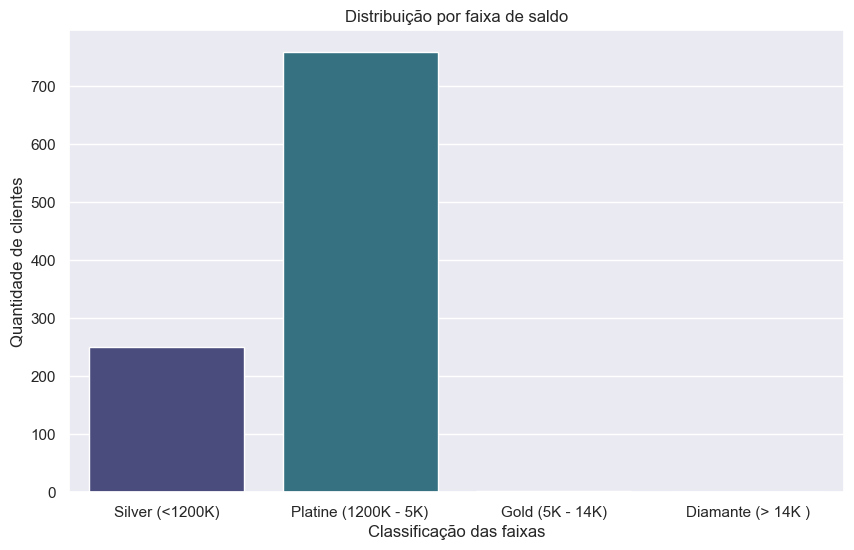

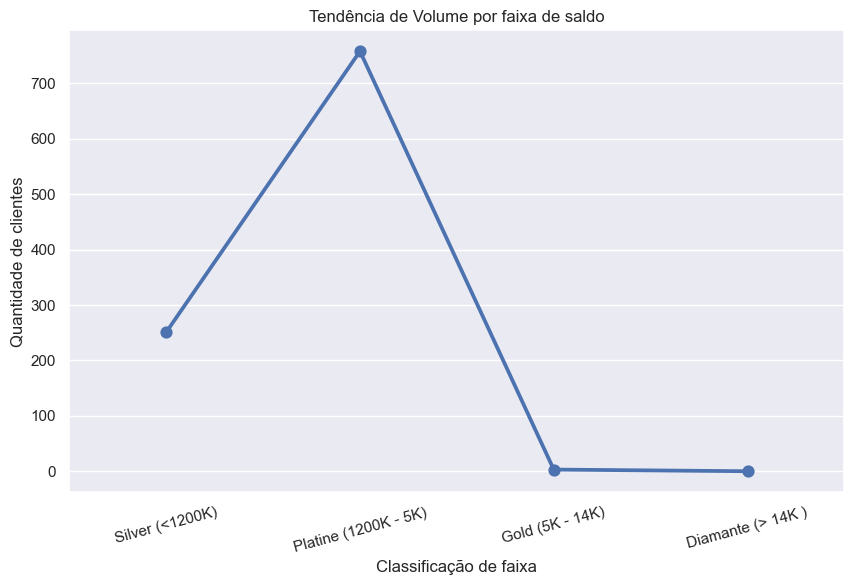

In [30]:
import matplotlib.pyplot as plt 
import seaborn as sns

bins = [0  , 1200 , 5000, 14000, float('inf')]
labels = ['Silver (<1200K)' ,  'Platine (1200K - 5K)' , 'Gold (5K - 14K)' , 'Diamante (> 14K )']

df_completo['Faixa_saldo'] = pd.cut(df_completo ['saldo'] , bins = bins , labels= labels)

distribuicao = df_completo['Faixa_saldo'].value_counts().reindex(labels)

def plot_3_bar (distribucao) : 
    plt.figure(figsize=(10,6))
    sns.barplot(x = distribucao.index , y = distribucao.values , palette= 'viridis' , hue= distribucao.index, legend=False)
    plt.title ("Distribuição por faixa de saldo")
    plt.ylabel('Quantidade de clientes')
    plt.xlabel('Classificação das faixas')
    return plt.show()

plot_3_bar(distribucao=distribuicao)

## Construção de um gráfico mais robusto

def plot_3_dif (dist) : 

    df_plot = dist.reset_index()
    df_plot.columns = ['Classificação de faixa', 'Quantidade de clientes']

    plt.figure(figsize=(10,6))
    sns.set_theme(style='darkgrid')

    sns.pointplot( data= df_plot, x ='Classificação de faixa' , y='Quantidade de clientes' )

    plt.title('Tendência de Volume por faixa de saldo')
    plt.xticks(rotation=15)
    plt.show()

plot_3_dif(distribuicao)


    